In [38]:
%matplotlib inline

from functools import partial

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.optimize import fsolve

from hippocampus import ASWR_NODP_DEFAULT_PARAMS, HippocampalCA3Node
from phase_plane_analysis import PhasePlaneAnalysis

plt.style.use("default_light")

/usr/local/opt/python@3.7/Frameworks/Python.framework/Versions/3.7/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [25]:
# all firing rates are in kHz
MAX_P_FR = 0.07
MAX_B_FR = 0.12
MAX_A_FR = 0.015


def init_hc_node(e=0.4):
    hc = HippocampalCA3Node(aswr_params={**ASWR_NODP_DEFAULT_PARAMS, "e": e})
    hc.index = 0
    hc.idx_state_var = 0
    hc.init_node()
    pp = PhasePlaneAnalysis(hc)
    return pp


def compute_A_steady_state(ode_system, p_mesh, b_mesh):
    assert p_mesh.shape == b_mesh.shape
    a_ss = np.zeros_like(p_mesh)
    for i in range(p_mesh.shape[0]):
        for j in range(p_mesh.shape[1]):
            a_ss[i, j] = fsolve(
                partial(
                    lambda r_mean_aSWR, r_mean_EXC, r_mean_INH: ode_system[-1](
                        r_mean_EXC, r_mean_INH, r_mean_aSWR
                    ),
                    r_mean_EXC=p_mesh[i, j],
                    r_mean_INH=b_mesh[i, j],
                ),
                [0.0],
            )
    return a_ss


def compute_B_steady_state(ode_system, p_mesh, a_mesh):
    assert p_mesh.shape == a_mesh.shape
    b_ss = np.zeros_like(p_mesh)
    for i in range(p_mesh.shape[0]):
        for j in range(p_mesh.shape[1]):
            b_ss[i, j] = fsolve(
                partial(
                    lambda r_mean_INH, r_mean_EXC, r_mean_aSWR: ode_system[1](
                        r_mean_EXC, r_mean_INH, r_mean_aSWR
                    ),
                    r_mean_EXC=p_mesh[i, j],
                    r_mean_aSWR=a_mesh[i, j],
                ),
                [0.0],
            )
    return b_ss

In [43]:
# prepare plotting grid
pb_mesh, bp_mesh = np.meshgrid(
    np.arange(-0.05 * MAX_P_FR, MAX_P_FR, 0.005 * MAX_P_FR),
    np.arange(-0.05 * MAX_B_FR, MAX_B_FR, 0.005 * MAX_B_FR),
)

pa_mesh, ap_mesh = np.meshgrid(
    np.arange(-0.05 * MAX_P_FR, MAX_P_FR, 0.005 * MAX_P_FR),
    np.arange(-0.05 * MAX_A_FR, MAX_A_FR, 0.005 * MAX_A_FR),
)

In [44]:
# compute for e=0.4
pp = init_hc_node(e=0.4)

a_ss = compute_A_steady_state(pp.lambdify_odes(), pb_mesh, bp_mesh)
pb04_nullclines = pp.lambdify_odes()[0](pb_mesh, bp_mesh, a_ss)
b04_nullclines = pp.lambdify_odes()[1](pb_mesh, bp_mesh, a_ss)

b_ss = compute_B_steady_state(pp.lambdify_odes(), pa_mesh, ap_mesh)
pa04_nullclines = pp.lambdify_odes()[0](pa_mesh, b_ss, ap_mesh)
a04_nullclines = pp.lambdify_odes()[2](pa_mesh, b_ss, ap_mesh)

/Users/nikola/.virtualenvs/paper_hc/lib/python3.7/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


In [45]:
# compute for e=0.5
pp = init_hc_node(e=0.5)

a_ss = compute_A_steady_state(pp.lambdify_odes(), pb_mesh, bp_mesh)
pb05_nullclines = pp.lambdify_odes()[0](pb_mesh, bp_mesh, a_ss)
b05_nullclines = pp.lambdify_odes()[1](pb_mesh, bp_mesh, a_ss)

b_ss = compute_B_steady_state(pp.lambdify_odes(), pa_mesh, ap_mesh)
pa05_nullclines = pp.lambdify_odes()[0](pa_mesh, b_ss, ap_mesh)
a05_nullclines = pp.lambdify_odes()[2](pa_mesh, b_ss, ap_mesh)

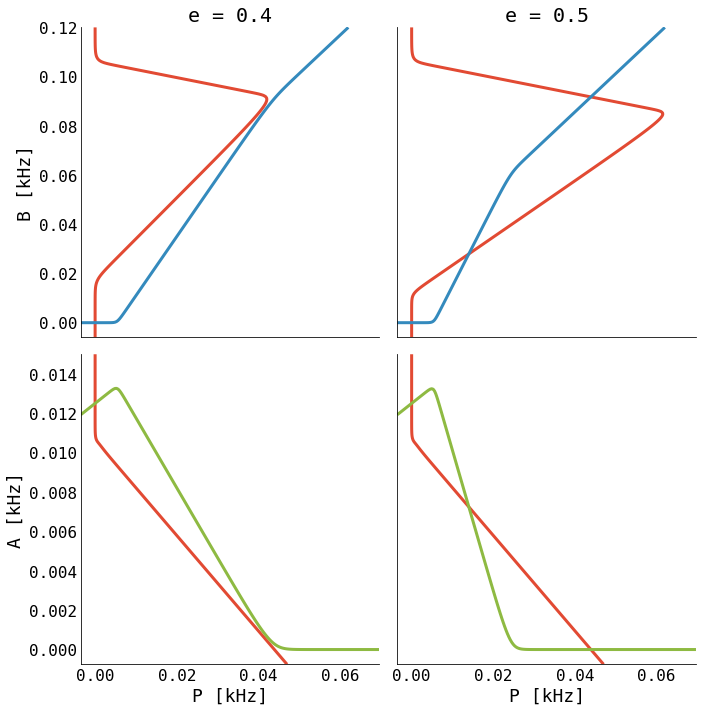

In [56]:
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(10, 10), sharex=True, sharey="row")

axs[0, 0].contour(
    pb_mesh, bp_mesh, pb04_nullclines, levels=[0], colors="C0", linewidths=3
)
axs[0, 0].contour(
    pb_mesh, bp_mesh, b04_nullclines, levels=[0], colors="C1", linewidths=3
)
axs[0, 0].set_ylabel("B [kHz]")
axs[0, 1].contour(
    pb_mesh, bp_mesh, pb05_nullclines, levels=[0], colors="C0", linewidths=3
)
axs[0, 1].contour(
    pb_mesh, bp_mesh, b05_nullclines, levels=[0], colors="C1", linewidths=3
)

axs[1, 0].contour(
    pa_mesh, ap_mesh, pa04_nullclines, levels=[0], colors="C0", linewidths=3
)
axs[1, 0].contour(
    pa_mesh, ap_mesh, a04_nullclines, levels=[0], colors="C5", linewidths=3
)
axs[1, 0].set_ylabel("A [kHz]")
axs[1, 1].contour(
    pa_mesh, ap_mesh, pa05_nullclines, levels=[0], colors="C0", linewidths=3
)
axs[1, 1].contour(
    pa_mesh, ap_mesh, a05_nullclines, levels=[0], colors="C5", linewidths=3
)

for ax in axs.flatten():
    sns.despine(ax=ax)

axs[0, 0].set_title(r"e = 0.4")
axs[0, 1].set_title(r"e = 0.5")
axs[1, 0].set_xlabel("P [kHz]")
axs[1, 1].set_xlabel("P [kHz]")

plt.tight_layout()

plt.savefig("../figs/nullclines.pdf", transparent=True, bbox_inches="tight")